In [284]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [285]:
TRAY_HSV_LOWER_BOUND = (85, 40, 20)
TRAY_HSV_UPPER_BOUND = (130, 255, 255)

TRAY_BOX_PIX = (
    250,
    20,
    630,
    300,
)  # (x1, y1, x2, y2) coordinates of the tray box in the image

CHEESE_W = 97


In [286]:
first_img_path = "/home/parth/snaak/data/SCH_images_041125/cheese_check_4/image_20250411-150654.png"
second_img_path = "/home/parth/snaak/data/SCH_images_041125/cheese_check_4/image_20250411-150700.png"

NUM_SLICE = 2

first_img = cv2.imread(first_img_path)
second_img = cv2.imread(second_img_path)

# resize the images to 840x480
first_img = cv2.resize(first_img, (840, 480))
second_img = cv2.resize(second_img, (840, 480))

In [287]:
# Crop the tray box from the bread image
first_crop = first_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

# Crop the tray box from the first ham image
second_crop = second_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

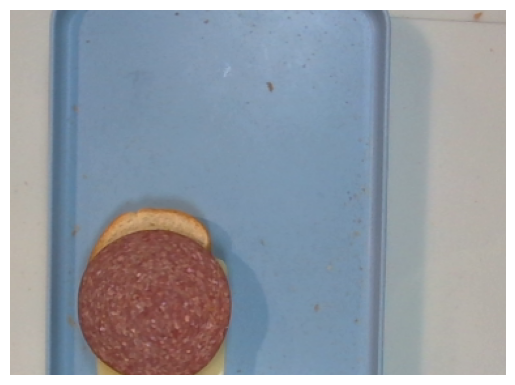

In [288]:
plt.imshow(cv2.cvtColor(first_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

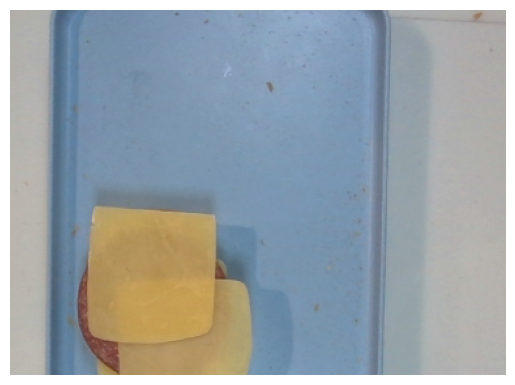

In [289]:
plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [290]:
# Segment tray from the second image using tray HSV values
# Convert the image to HSV color space
second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
tray_hsv_lower_bound = np.array(TRAY_HSV_LOWER_BOUND, dtype=np.uint8)
tray_hsv_upper_bound = np.array(TRAY_HSV_UPPER_BOUND, dtype=np.uint8)
tray_mask = cv2.inRange(second_hsv, tray_hsv_lower_bound, tray_hsv_upper_bound)

# Invert the tray mask
tray_mask_inv = cv2.bitwise_not(tray_mask)

# Find the bounding box of the tray
contours, _ = cv2.findContours(tray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    tray_x, tray_y, tray_w, tray_h = cv2.boundingRect(largest_contour)


# Black out everything outside the tray box coordinate in tray_mask_inv
tray_mask_inv[0:tray_y+5, :] = 0
tray_mask_inv[tray_y+tray_h-5:, :] = 0
tray_mask_inv[:, 0:tray_x+5] = 0
tray_mask_inv[:, tray_x+tray_w-5:] = 0

# plt.imshow(tray_mask_inv, cmap='gray')
# plt.axis('off')
# plt.show()

In [291]:
BREAD_HSV_LOWER_BOUND_STRICT = (10, 60, 100)
BREAD_HSV_UPPER_BOUND_STRICT = (20, 110, 220)

second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
bread_hsv_lower_bound = np.array(BREAD_HSV_LOWER_BOUND_STRICT, dtype=np.uint8)
bread_hsv_upper_bound = np.array(BREAD_HSV_UPPER_BOUND_STRICT, dtype=np.uint8)
bread_mask = cv2.inRange(second_hsv, bread_hsv_lower_bound, bread_hsv_upper_bound)
bread_mask_inv = cv2.bitwise_not(bread_mask)

# plt.imshow(bread_mask, cmap='gray')
# plt.axis('off')
# plt.show()

In [292]:
# Calculate the difference between the two images
diff = cv2.absdiff(first_crop, second_crop)
gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

# plt.imshow(gray_diff, cmap='gray')
# plt.axis('off')
# plt.show()


# And operate the difference image with bread mask and tray mask
gray_diff = cv2.bitwise_and(gray_diff, gray_diff, mask=tray_mask_inv)
gray_diff = cv2.bitwise_and(gray_diff, gray_diff, mask=bread_mask_inv)


# Remove noise from the difference image
gray_diff = cv2.GaussianBlur(gray_diff, (9, 9), 0)

# plt.imshow(gray_diff, cmap='gray')
# plt.axis('off')
# plt.show()

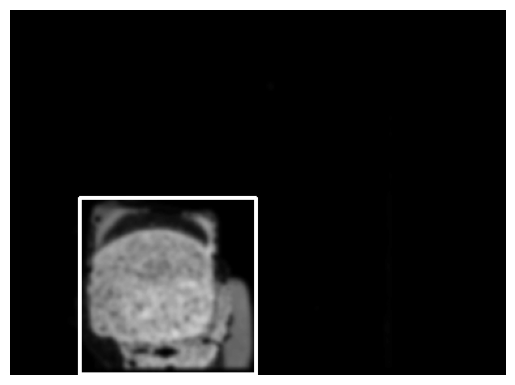

In [293]:
search_cheese_w = int(CHEESE_W + 0.4 * CHEESE_W * (NUM_SLICE-1))

cheese_box = [0, 0, search_cheese_w, search_cheese_w] # (x1, y1, x2, y2) coordinates of the cheese box in the image

max_sum = 0
best_cheese_box = None

# Slide the cheese box over the image
for col in range(0, gray_diff.shape[1] - search_cheese_w): # iterate along image width
    cheese_box[0] = col
    cheese_box[2] = col + search_cheese_w

    for row in range(0, gray_diff.shape[0] - search_cheese_w): # iterate along image height
        cheese_box[1] = row
        cheese_box[3] = row + search_cheese_w

        cheese_crop = gray_diff[cheese_box[1]:cheese_box[3], cheese_box[0]:cheese_box[2]]
        cheese_crop_sum = np.sum(cheese_crop)
        if cheese_crop_sum > max_sum:
            max_sum = cheese_crop_sum
            best_cheese_box = cheese_box.copy()

# Draw the best cheese box on the difference image
plot_img = gray_diff.copy()
plot_img = cv2.rectangle(plot_img, (best_cheese_box[0], best_cheese_box[1]), (best_cheese_box[2], best_cheese_box[3]), (100, 100, 100), 2)
plt.imshow(plot_img, cmap='gray')
plt.axis('off')
plt.show()

# Draw the best cheese box on the image
# plot_img = second_crop.copy()
# plot_img = cv2.rectangle(plot_img, (best_cheese_box[0], best_cheese_box[1]), (best_cheese_box[2], best_cheese_box[3]), (0, 255, 0), 2)
# plt.imshow(plot_img)
# plt.axis('off')
# plt.show()

    

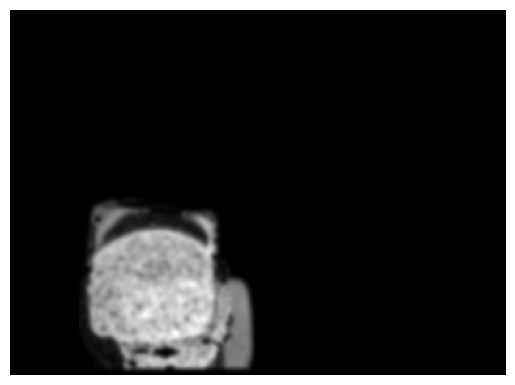

In [294]:
# Blacken out everything outside the cheese box
gray_diff_new = np.zeros_like(gray_diff)
gray_diff_new[best_cheese_box[1]:best_cheese_box[3], best_cheese_box[0]:best_cheese_box[2]] = gray_diff[best_cheese_box[1]:best_cheese_box[3], best_cheese_box[0]:best_cheese_box[2]]
gray_diff = gray_diff_new

plt.imshow(gray_diff, cmap='gray')
plt.axis('off')
plt.show()

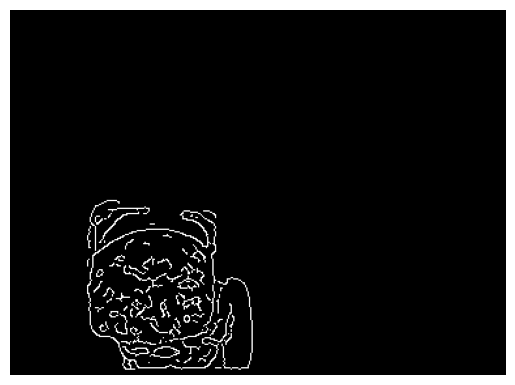

In [295]:
# Apply edge detection to the difference image
edges = cv2.Canny(gray_diff, 20, 30)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

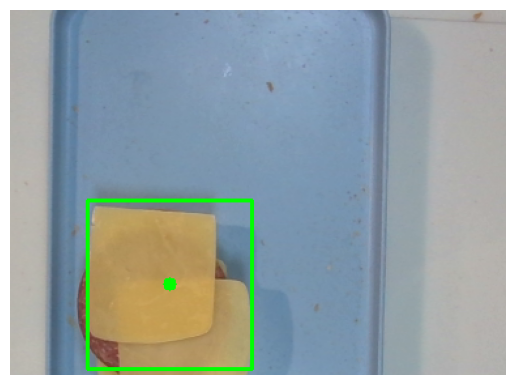

In [296]:
# Find a box that can encompass all the white pixels in the edge image using np.where
y_indices, x_indices = np.where(edges > 0)
if len(x_indices) > 0 and len(y_indices) > 0:
    x1, x2 = np.min(x_indices), np.max(x_indices)
    y1, y2 = np.min(y_indices), np.max(y_indices)

    plot_img = second_crop.copy()
    # Draw the box on the edge image
    plot_img = cv2.rectangle(plot_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw the center of the box
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    plot_img = cv2.circle(plot_img, (center_x, center_y), 5, (0, 255, 0), -1)

    plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()  

In [297]:
# Hough Line Transform
# lines = cv2.HoughLinesP(
#     edges, 
#     rho=1, 
#     theta=np.pi/180 * 3, 
#     threshold=20, 
#     minLineLength=10, 
#     maxLineGap=5
# )

# plot_img = edges.copy()
# plot_img = cv2.cvtColor(plot_img, cv2.COLOR_GRAY2BGR)

# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         cv2.line(plot_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# plt.imshow(plot_img)
# plt.axis('off')
# plt.show()

# print(len(lines))

In [298]:
# # Fit a bounding box to the detected lines
# if lines is not None:
#     x_coords = []
#     y_coords = []
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         x_coords.extend([x1, x2])
#         y_coords.extend([y1, y2])

#     min_x = min(x_coords)
#     max_x = max(x_coords)
#     min_y = min(y_coords)
#     max_y = max(y_coords)

#     # Draw the bounding box and the center of the box on plot image
#     plot_img = second_crop.copy()
#     plot_img = cv2.rectangle(plot_img, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
#     center_x = (min_x + max_x) // 2
#     center_y = (min_y + max_y) // 2
#     plot_img = cv2.circle(plot_img, (center_x, center_y), 5, (0, 0, 255), -1)
#     plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

In [299]:
# # Generate a convex hull for the line
# points = []
# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         points.append((x1, y1))
#         points.append((x2, y2))

# # Step 4: Convex Hull
# points = np.array(points)
# hull = cv2.convexHull(points)

# # Find the center of the convex hull
# M = cv2.moments(hull)
# if M["m00"] != 0:
#     cx = int(M["m10"] / M["m00"])
#     cy = int(M["m01"] / M["m00"])
# else:
#     cx, cy = 0, 0

# # Step 5: Draw Results
# img_color = cv2.cvtColor(gray_diff, cv2.COLOR_GRAY2BGR).copy()

# # Draw lines
# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         cv2.line(img_color, (x1, y1), (x2, y2), (0, 255, 0), 2)

# # Draw convex hull
# cv2.polylines(img_color, [hull], isClosed=True, color=(0, 0, 255), thickness=1)

# # Show
# plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

# Plot the hull and center of hull on the second crop image
# plot_img = second_crop.copy()
# plot_img = cv2.drawContours(plot_img, [hull], -1, (0, 255, 0), 2)
# plot_img = cv2.circle(plot_img, (cx, cy), 5, (0, 255, 0), -1)
# plt.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

In [300]:
# Threshold it (just in case)
# _, thresh = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

# # Find contours
# contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Combine all contour points into one big array
# all_points = np.vstack(contours)

# # Find convex hull
# hull = cv2.convexHull(all_points)

# # Find the center of the convex hull
# M = cv2.moments(hull)
# if M["m00"] != 0:
#     cx = int(M["m10"] / M["m00"])
#     cy = int(M["m01"] / M["m00"])
# else:
#     cx, cy = 0, 0

# # Draw the convex hull on difference image
# plot_img = gray_diff.copy()
# plot_img = cv2.cvtColor(plot_img, cv2.COLOR_GRAY2BGR)
# plot_img = cv2.drawContours(plot_img, [hull], -1, (100, 100, 100), 2)
# plt.imshow(plot_img)
# plt.axis('off')
# plt.show()